1. Train at least two classifiers without dimensionality reduction on this dataset.
    * Carry the standard hyperparameter tuning.
    * Report performance measures (accuracy score and f1-score), and training time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import time
import joblib

# Load dataset
X = np.load('ship_data.npy')     
y = np.load('ship_labels.npy')   

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape data to 2D for model training (flatten each image)
n_samples, height, width, channels = X_train.shape
X_train_flat = X_train.reshape(n_samples, height * width * channels)
X_test_flat = X_test.reshape(X_test.shape[0], height * width * channels)
X.shape, y.shape

((4000, 80, 80, 3), (4000,))

In [2]:
# Question 1: Train classifiers without dimensionality reduction
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100]}  # Regularization parameter grid
lr_grid = GridSearchCV(lr, param_grid_lr, scoring='accuracy')
start_time = time.time()
lr_grid.fit(X_train_flat, y_train)
lr_no_reduction = lr_grid.best_estimator_
lr_time = time.time() - start_time
lr_accuracy = accuracy_score(y_test, lr_no_reduction.predict(X_test_flat))
lr_f1 = f1_score(y_test, lr_no_reduction.predict(X_test_flat))

# Report metrics
print(f"Logistic Regression No Reduction - Accuracy: {lr_accuracy:.4f}, F1-Score: {lr_f1:.4f}, Training Time: {lr_time:.2f}s")

# Random Forest
rf = RandomForestClassifier()
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20]}
rf_grid = GridSearchCV(rf, param_grid_rf, scoring='accuracy')
start_time = time.time()
rf_grid.fit(X_train_flat, y_train)
rf_no_reduction = rf_grid.best_estimator_
rf_time = time.time() - start_time
rf_accuracy = accuracy_score(y_test, rf_no_reduction.predict(X_test_flat))
rf_f1 = f1_score(y_test, rf_no_reduction.predict(X_test_flat))

# Report metrics
print(f"RF No Reduction - Accuracy: {rf_accuracy}, F1-Score: {rf_f1}, Training Time: {rf_time}")

Logistic Regression No Reduction - Accuracy: 0.8875, F1-Score: 0.8009, Training Time: 499.92s
RF No Reduction - Accuracy: 0.95, F1-Score: 0.8963730569948186, Training Time: 645.0835602283478


In [39]:
import joblib

In [40]:
joblib.dump(lr_no_reduction,"Q1LinearRegression.pkl")
joblib.dump(rf_no_reduction,"Q1RandomForest.pkl")

['Q1RandomForest.pkl']

Number of PCA components to explain 90% variance: 108


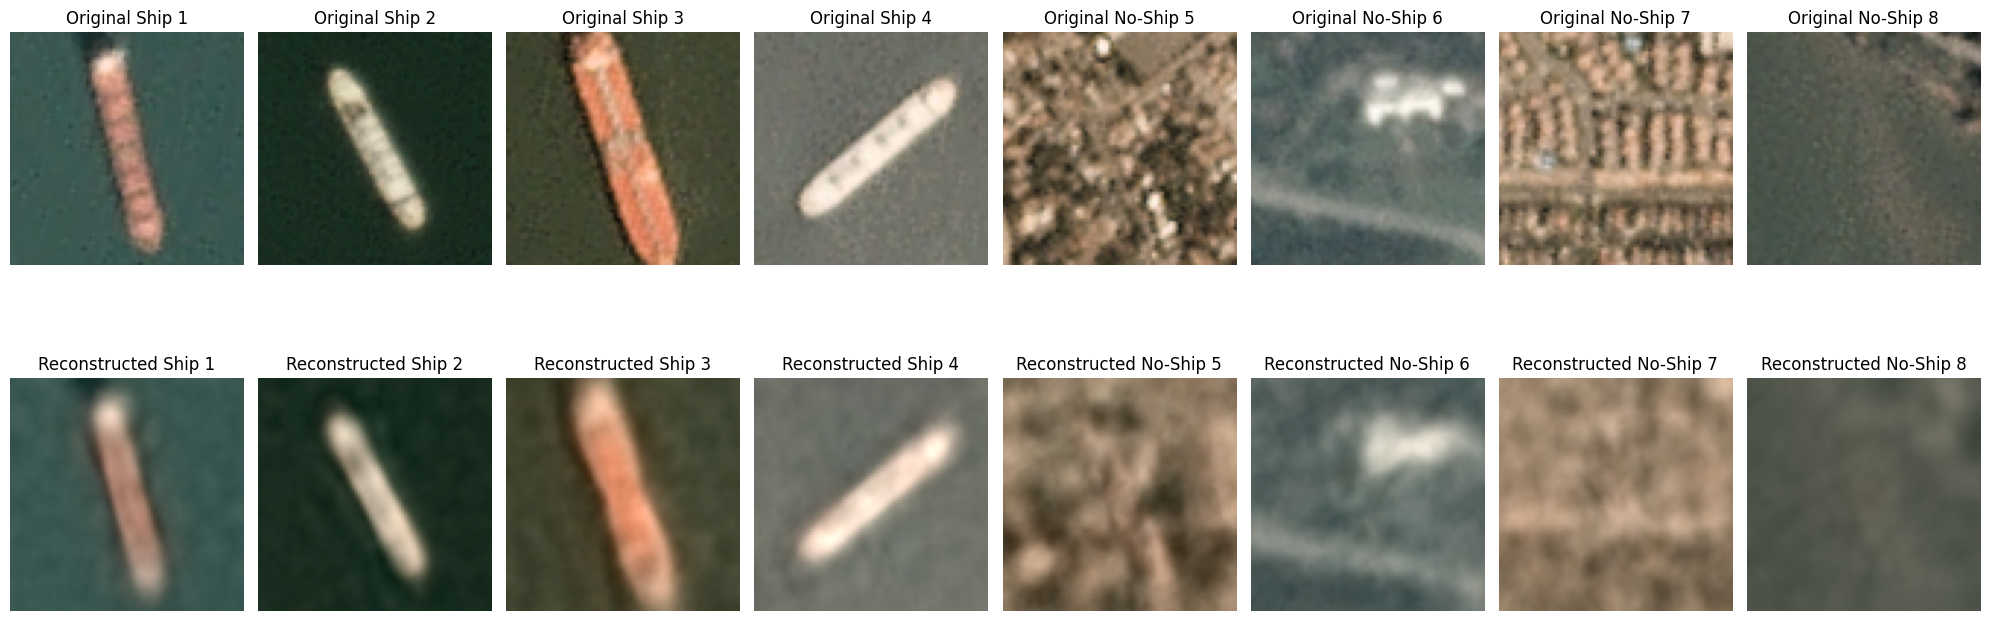

Length of rmse_per_component: 108
Number of PCA components: 108
Average RMSE: 0.4113021873629629


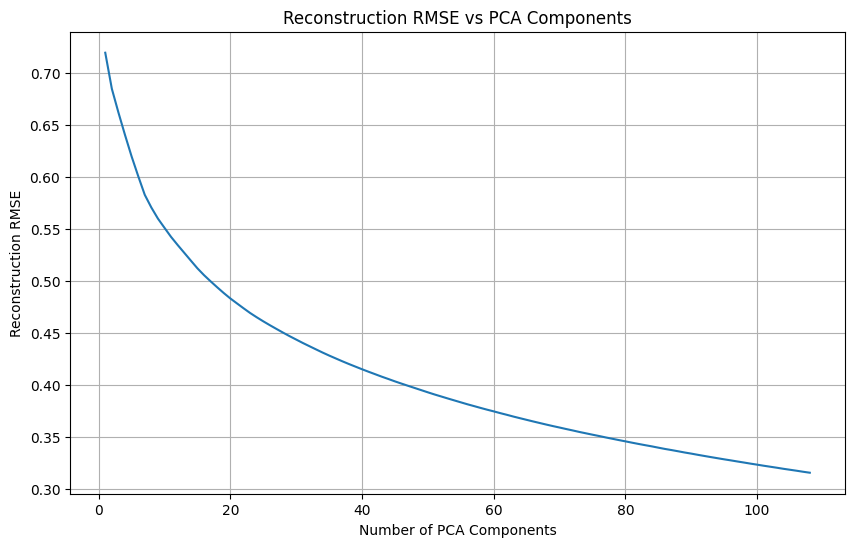

In [6]:
from sklearn.preprocessing import StandardScaler  
def plot_reconstructed_images(X_original, y, pca, n_samples=4):
    """
    Visualize reconstructed images for ship and no-ship categories
    """
    # Separate ship and no-ship indices
    ship_indices = np.where(y == 1)[0]
    no_ship_indices = np.where(y == 0)[0]
    
    # Create figure
    fig, axes = plt.subplots(2, 2*n_samples, figsize=(20, 8))
    
    # Standardize data for reconstruction
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_original)
    
    # Function to process and display images
    def process_and_display_image(idx, col_idx, is_ship=True):
        # Original image
        original_img = X_original[idx].reshape(height, width, channels)
        axes[0, col_idx].imshow(original_img)
        axes[0, col_idx].set_title(f"Original {'Ship' if is_ship else 'No-Ship'} {col_idx+1}")
        axes[0, col_idx].axis('off')
        
        # Get reconstructed image
        X_scaled_sample = X_scaled[idx].reshape(1, -1)
        X_pca_transformed = pca.transform(X_scaled_sample)
        X_reconstructed = pca.inverse_transform(X_pca_transformed)
        
        # Inverse transform the standardization
        reconstructed_img = scaler.inverse_transform(X_reconstructed).reshape(height, width, channels)
        
        # Clip values to valid range for display
        reconstructed_img = np.clip(reconstructed_img, 0, 255).astype(np.uint8)
        
        axes[1, col_idx].imshow(reconstructed_img)
        axes[1, col_idx].set_title(f"Reconstructed {'Ship' if is_ship else 'No-Ship'} {col_idx+1}")
        axes[1, col_idx].axis('off')
    
    # Process ship images
    for i in range(n_samples):
        idx = np.random.choice(ship_indices)
        process_and_display_image(idx, i, is_ship=True)
    
    # Process no-ship images
    for i in range(n_samples):
        idx = np.random.choice(no_ship_indices)
        process_and_display_image(idx, n_samples + i, is_ship=False)
    
    plt.tight_layout()
    plt.show()

# Prepare data
X_flat = X.reshape(X.shape[0], -1)
height, width, channels = X.shape[1], X.shape[2], X.shape[3]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# PCA with 90% variance explained
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X_scaled)

print("Number of PCA components to explain 90% variance:", pca.n_components_)

# Visualize reconstructed images
plot_reconstructed_images(X_flat, y, pca, n_samples=4)
rmse_per_component = []  # Clear any residual values

# Calculate RMSE for each number of PCA components
for n in range(1, pca.n_components_ + 1):
    pca_temp = PCA(n_components=n)
    X_pca_temp = pca_temp.fit_transform(X_scaled)
    X_reconstructed_temp = pca_temp.inverse_transform(X_pca_temp)
    
    # Calculate RMSE for reconstruction
    rmse = np.sqrt(np.mean((X_scaled - X_reconstructed_temp) ** 2))
    rmse_per_component.append(rmse)

# Debugging outputs
print(f"Length of rmse_per_component: {len(rmse_per_component)}")
print(f"Number of PCA components: {pca.n_components_}")

# Calculate and print the average RMSE
average_rmse = np.mean(rmse_per_component)
print("Average RMSE:", average_rmse)

# Plot the RMSE per component
plt.figure(figsize=(10, 6))
plt.plot(range(1, pca.n_components_ + 1), rmse_per_component)
plt.xlabel('Number of PCA Components')
plt.ylabel('Reconstruction RMSE')
plt.title('Reconstruction RMSE vs PCA Components')
plt.grid(True)
plt.show()

In [6]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
import time

In [ ]:
#3. Train a pipelinefor the same classifiers in part (1) with dimensionality reduction via PCA.
   # * Carry the standard hyperparameter tuning (including n_components).
    #* Compare performance measures and training time.
    
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('rf', RandomForestClassifier())
])

# Hyperparameter grids

param_grid_rf_pca = {
    'pca__n_components': [10, 20, 30],  
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [5, 10, 20]
}


# Define pipeline for Logistic Regression with PCA
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('lr', LogisticRegression(max_iter=1000))
])

# Hyperparameter grid
param_grid_lr_pca = {
    'pca__n_components': [10, 20, 30],  
    'lr__C': [0.01, 0.1, 1, 10, 100]   # Regularization strength
}

# Train Logistic Regression with PCA
lr_grid_pca = GridSearchCV(pipeline_lr, param_grid_lr_pca, scoring='accuracy', cv=3, n_jobs=-1)
start_time = time.time()
lr_grid_pca.fit(X_train_flat, y_train)
lr_with_pca = lr_grid_pca.best_estimator_
lr_pca_time = time.time() - start_time
lr_pca_accuracy = accuracy_score(y_test, lr_with_pca.predict(X_test_flat))
lr_pca_f1 = f1_score(y_test, lr_with_pca.predict(X_test_flat))

# Report metrics
print(f"Logistic Regression with PCA - Accuracy: {lr_pca_accuracy:.4f}, F1-Score: {lr_pca_f1:.4f}, Training Time: {lr_pca_time:.2f}s")

# Train Random Forest with PCA
rf_grid_pca = GridSearchCV(pipeline_rf, param_grid_rf_pca, scoring='accuracy', cv=3)
start_time = time.time()
rf_grid_pca.fit(X_train_flat, y_train)
rf_with_pca = rf_grid_pca.best_estimator_
rf_pca_time = time.time() - start_time
rf_pca_accuracy = accuracy_score(y_test, rf_with_pca.predict(X_test_flat))
rf_pca_f1 = f1_score(y_test, rf_with_pca.predict(X_test_flat))
# Report metrics
print(f"Randomforest with PCA - Accuracy: {rf_pca_accuracy:.4f}, F1-Score: {rf_pca_f1:.4f}, Training Time: {rf_pca_time:.2f}s")

Logistic Regression with PCA - Accuracy: 0.8688, F1-Score: 0.7273, Training Time: 55.71s
Randomforest with PCA - Accuracy: 0.9550, F1-Score: 0.9058, Training Time: 278.74s


In [10]:
joblib.dump(lr_with_pca,"Q3linearRegression.pkl")
joblib.dump(rf_with_pca,"Q3randomForest.pkl")

['Q3randomForest.pkl']

Q4. Repeat question (3) for using manifold learning algorithms. Utilize the new lower-dimensional feature space to build a classifier.
    * Use the same classifiers.
    * Compare performance metrics and training/inference time with those for question (3) and (1).
    * Visualize and interpret what the first 2 dimensions in the manifold learning algorithms you train. Use the ```plot_components``` function presented in lecture.


Training ISOMAP with n_neighbors = 5


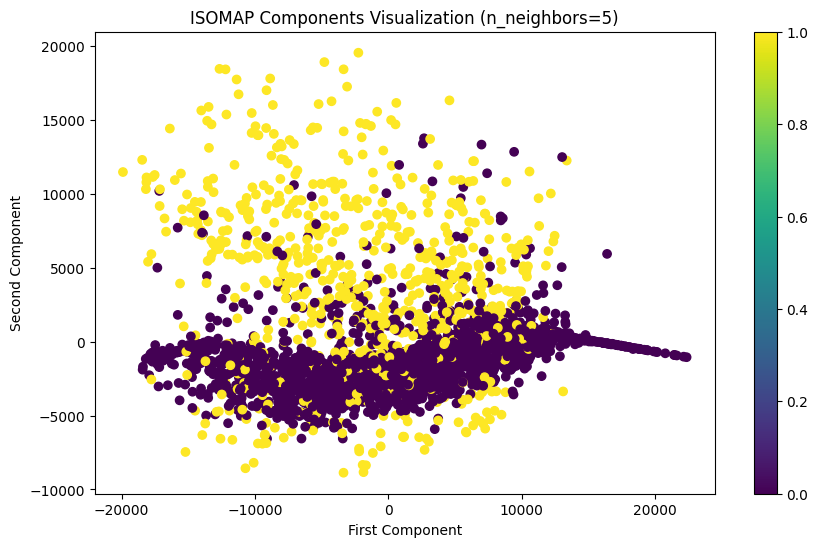

Logistic Regression with ISOMAP (n_neighbors=5) - Accuracy: 0.8287, F1-Score: 0.5566, Training Time: 7.92s
Random Forest with ISOMAP (n_neighbors=5) - Accuracy: 0.8738, F1-Score: 0.7233, Training Time: 23.11s

Training ISOMAP with n_neighbors = 10


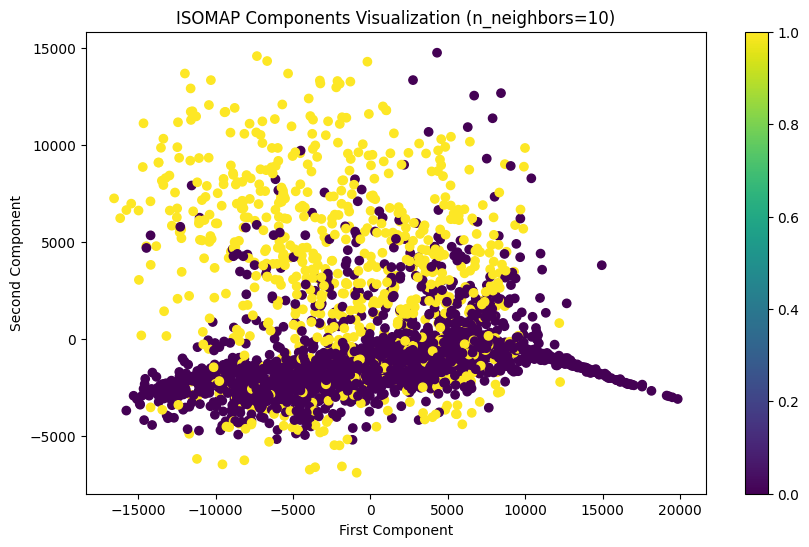

Logistic Regression with ISOMAP (n_neighbors=10) - Accuracy: 0.8375, F1-Score: 0.5886, Training Time: 8.64s
Random Forest with ISOMAP (n_neighbors=10) - Accuracy: 0.8600, F1-Score: 0.7083, Training Time: 23.57s

Training ISOMAP with n_neighbors = 20


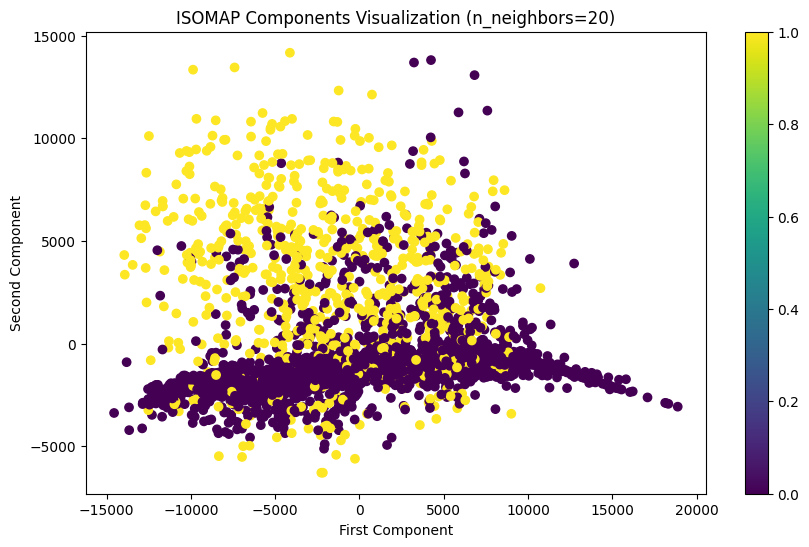

Logistic Regression with ISOMAP (n_neighbors=20) - Accuracy: 0.8263, F1-Score: 0.5531, Training Time: 9.24s
Random Forest with ISOMAP (n_neighbors=20) - Accuracy: 0.8450, F1-Score: 0.6667, Training Time: 23.71s

Comparative Analysis:
1. Original Data (No Reduction):
LR - Accuracy: 0.8875, F1: 0.8009, Time: 499.92s
RF - Accuracy: 0.9500, F1: 0.8964, Time: 645.08s

2. PCA:
LR - Accuracy: 0.8688, F1: 0.7273, Time: 55.71s
RF - Accuracy: 0.9550, F1: 0.9058, Time: 278.74s

3. ISOMAP Results:

ISOMAP with n_neighbors = 5:
LR - Accuracy: 0.8287, F1: 0.5566, Time: 7.92s
RF - Accuracy: 0.8738, F1: 0.7233, Time: 23.11s

ISOMAP with n_neighbors = 10:
LR - Accuracy: 0.8375, F1: 0.5886, Time: 8.64s
RF - Accuracy: 0.8600, F1: 0.7083, Time: 23.57s

ISOMAP with n_neighbors = 20:
LR - Accuracy: 0.8263, F1: 0.5531, Time: 9.24s
RF - Accuracy: 0.8450, F1: 0.6667, Time: 23.71s


In [ ]:
import numpy as np
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import Isomap
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import joblib

# Function to plot components
def plot_components(X_transformed, y, title):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y, cmap='viridis')
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('First Component')
    plt.ylabel('Second Component')
    plt.show()

# ISOMAP Pipeline
def train_with_isomap(X_train, X_test, y_train, y_test, n_neighbors=5, n_components=2):
    # ISOMAP transformation
    isomap = Isomap(n_components=n_components, n_neighbors=n_neighbors)
    start_time = time.time()
    X_train_iso = isomap.fit_transform(X_train)
    X_test_iso = isomap.transform(X_test)
    iso_time = time.time() - start_time
    
    # Visualize first 2 components
    if n_components >= 2:
        plot_components(X_train_iso, y_train, f'ISOMAP Components Visualization (n_neighbors={n_neighbors})')
    
    return X_train_iso, X_test_iso, iso_time

# Train classifiers with ISOMAP
def train_classifiers_manifold(X_train_manifold, X_test_manifold, y_train, y_test, manifold_time, n_neighbors):
    results = {}
    
    # Logistic Regression
    lr = LogisticRegression(max_iter=1000)
    param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100]}
    lr_grid = GridSearchCV(lr, param_grid_lr, scoring='accuracy')
    
    start_time = time.time()
    lr_grid.fit(X_train_manifold, y_train)
    lr_train_time = time.time() - start_time + manifold_time
    
    lr_pred = lr_grid.predict(X_test_manifold)
    lr_accuracy = accuracy_score(y_test, lr_pred)
    lr_f1 = f1_score(y_test, lr_pred)
    
    print(f"Logistic Regression with ISOMAP (n_neighbors={n_neighbors}) - Accuracy: {lr_accuracy:.4f}, "
          f"F1-Score: {lr_f1:.4f}, Training Time: {lr_train_time:.2f}s")
    
    # Random Forest
    rf = RandomForestClassifier()
    param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 20]}
    rf_grid = GridSearchCV(rf, param_grid_rf, scoring='accuracy')
    
    start_time = time.time()
    rf_grid.fit(X_train_manifold, y_train)
    rf_train_time = time.time() - start_time + manifold_time
    
    rf_pred = rf_grid.predict(X_test_manifold)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    rf_f1 = f1_score(y_test, rf_pred)
    
    print(f"Random Forest with ISOMAP (n_neighbors={n_neighbors}) - Accuracy: {rf_accuracy:.4f}, "
          f"F1-Score: {rf_f1:.4f}, Training Time: {rf_train_time:.2f}s")
    
    results = {
        'lr_model': lr_grid.best_estimator_,
        'rf_model': rf_grid.best_estimator_,
        'lr_metrics': {'accuracy': lr_accuracy, 'f1': lr_f1, 'time': lr_train_time},
        'rf_metrics': {'accuracy': rf_accuracy, 'f1': rf_f1, 'time': rf_train_time}
    }
    
    return results

# Try different numbers of neighbors for ISOMAP
n_neighbors_list = [5, 10, 20]
isomap_results = {}

for n_neighbors in n_neighbors_list:
    print(f"\nTraining ISOMAP with n_neighbors = {n_neighbors}")
    X_train_iso, X_test_iso, iso_time = train_with_isomap(
        X_train_flat, X_test_flat, y_train, y_test, n_neighbors=n_neighbors
    )
    isomap_results[n_neighbors] = train_classifiers_manifold(
        X_train_iso, X_test_iso, y_train, y_test, iso_time, n_neighbors
    )
    

# Print comparative analysis
print("\nComparative Analysis:")
print("1. Original Data (No Reduction):")
print(f"LR - Accuracy: {lr_accuracy:.4f}, F1: {lr_f1:.4f}, Time: {lr_time:.2f}s")
print(f"RF - Accuracy: {rf_accuracy:.4f}, F1: {rf_f1:.4f}, Time: {rf_time:.2f}s")

print("\n2. PCA:")
print(f"LR - Accuracy: {lr_pca_accuracy:.4f}, F1: {lr_pca_f1:.4f}, Time: {lr_pca_time:.2f}s")
print(f"RF - Accuracy: {rf_pca_accuracy:.4f}, F1: {rf_pca_f1:.4f}, Time: {rf_pca_time:.2f}s")

print("\n3. ISOMAP Results:")
for n_neighbors in n_neighbors_list:
    print(f"\nISOMAP with n_neighbors = {n_neighbors}:")
    print(f"LR - Accuracy: {isomap_results[n_neighbors]['lr_metrics']['accuracy']:.4f}, "
          f"F1: {isomap_results[n_neighbors]['lr_metrics']['f1']:.4f}, "
          f"Time: {isomap_results[n_neighbors]['lr_metrics']['time']:.2f}s")
    print(f"RF - Accuracy: {isomap_results[n_neighbors]['rf_metrics']['accuracy']:.4f}, "
          f"F1: {isomap_results[n_neighbors]['rf_metrics']['f1']:.4f}, "
          f"Time: {isomap_results[n_neighbors]['rf_metrics']['time']:.2f}s")

In [32]:
# Save best models
joblib.dump(isomap_results[n_neighbors]['lr_model'], f"Q4_isomap_lr_k{n_neighbors}.pkl")
joblib.dump(isomap_results[n_neighbors]['rf_model'], f"Q4_isomap_rf_k{n_neighbors}.pkl")

['Q4_isomap_rf_k20.pkl']

5. What is the overall best ```pipeline```?
    * Report the confusion matrices.
    * Visualize misclassified samples. Do you see a pattern? Provide a discussion on how you would move forward to address the misclassifications.

Best Pipeline: RF (PCA) with accuracy: 0.9550


<Figure size 1000x800 with 0 Axes>

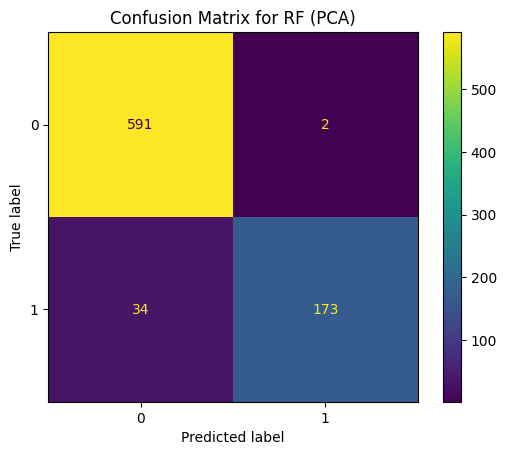

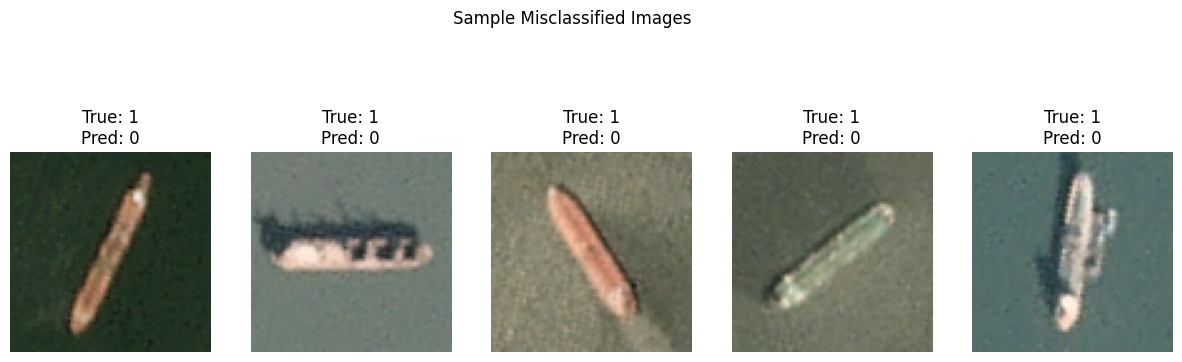


Misclassification Analysis:
Total misclassified samples: 36

Class-wise misclassification distribution:
Class 0: 2 samples
Class 1: 34 samples


In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def analyze_best_pipeline(X_test_flat, y_test, isomap_results, lr_accuracy, rf_accuracy, 
                         lr_pca_accuracy, rf_pca_accuracy, X_test):
    # Collect all accuracies
    accuracies = {
        'LR (No Reduction)': lr_accuracy,
        'RF (No Reduction)': rf_accuracy,
        'LR (PCA)': lr_pca_accuracy,
        'RF (PCA)': rf_pca_accuracy
    }
    
    # Add ISOMAP accuracies
    for n in isomap_results.keys():
        accuracies[f'LR (ISOMAP n={n})'] = isomap_results[n]['lr_metrics']['accuracy']
        accuracies[f'RF (ISOMAP n={n})'] = isomap_results[n]['rf_metrics']['accuracy']
    
    # Find best pipeline
    best_pipeline = max(accuracies.items(), key=lambda x: x[1])
    
    print(f"Best Pipeline: {best_pipeline[0]} with accuracy: {best_pipeline[1]:.4f}")
    
    # Get predictions and confusion matrix for best model
    if 'ISOMAP' in best_pipeline[0]:
        n_neighbors = int(best_pipeline[0].split('=')[1].replace(')', ''))
        if 'LR' in best_pipeline[0]:
            best_model = isomap_results[n_neighbors]['lr_model']
            X_transformed = Isomap(n_components=2, n_neighbors=n_neighbors).fit_transform(X_test_flat)
        else:
            best_model = isomap_results[n_neighbors]['rf_model']
            X_transformed = Isomap(n_components=2, n_neighbors=n_neighbors).fit_transform(X_test_flat)
    else:
        if 'LR' in best_pipeline[0]:
            if 'PCA' in best_pipeline[0]:
                best_model = lr_with_pca
            else:
                best_model = lr_no_reduction
        else:
            if 'PCA' in best_pipeline[0]:
                best_model = rf_with_pca
            else:
                best_model = rf_no_reduction
        X_transformed = X_test_flat
    
    # Get predictions
    y_pred = best_model.predict(X_transformed)
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix for {best_pipeline[0]}')
    plt.show()
    
    # Visualize misclassified samples
    misclassified_idx = np.where(y_test != y_pred)[0]
    
    if len(misclassified_idx) > 0:
        plt.figure(figsize=(15, 5))
        for i, idx in enumerate(misclassified_idx[:5]):  
            plt.subplot(1, 5, i+1)
            plt.imshow(X_test[idx])
            plt.title(f'True: {y_test[idx]}\nPred: {y_pred[idx]}')
            plt.axis('off')
        plt.suptitle('Sample Misclassified Images')
        plt.show()
        
        # Analysis of misclassifications
        print("\nMisclassification Analysis:")
        print(f"Total misclassified samples: {len(misclassified_idx)}")
        print("\nClass-wise misclassification distribution:")
        for true_class in np.unique(y_test):
            mask = y_test[misclassified_idx] == true_class
            print(f"Class {true_class}: {np.sum(mask)} samples")
            
        return misclassified_idx, y_test[misclassified_idx], y_pred[misclassified_idx]
    
# Run the analysis
misclassified_idx, true_labels, pred_labels = analyze_best_pipeline(
    X_test_flat, y_test, isomap_results, 
    lr_accuracy, rf_accuracy, 
    lr_pca_accuracy, rf_pca_accuracy,
    X_test
)

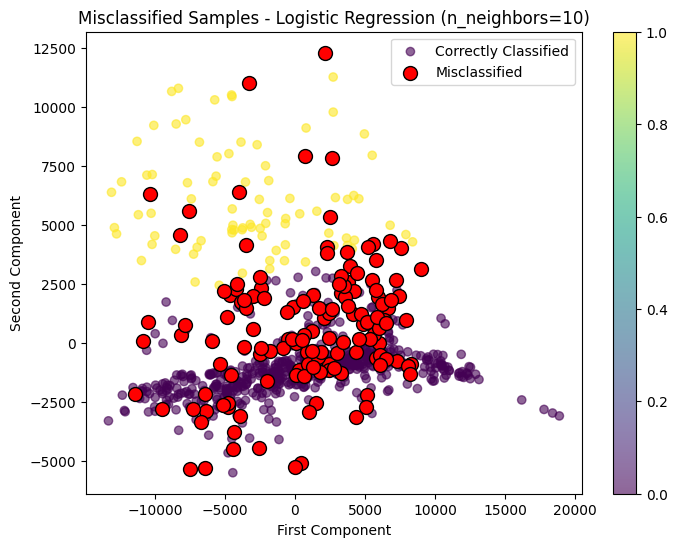

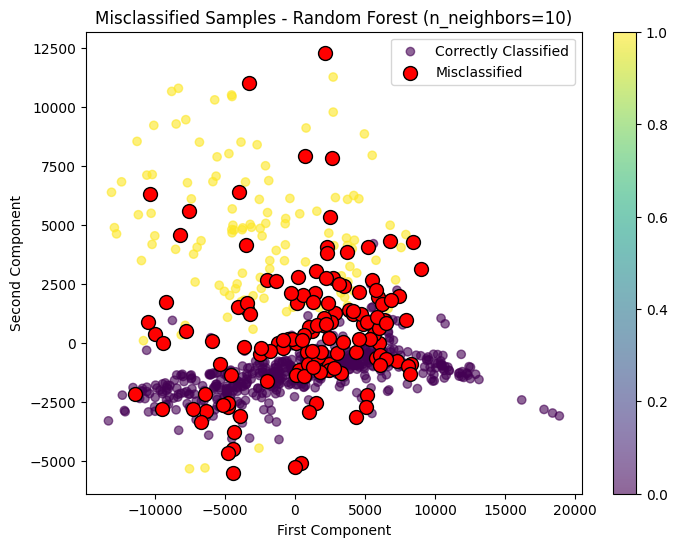

In [38]:
# Function to plot misclassified samples in ISOMAP space
def plot_misclassified_samples(X_test_iso, y_test, y_pred, title):
    misclassified_idx = np.where(y_test != y_pred)[0]
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_test_iso[:, 0], X_test_iso[:, 1], c=y_test, cmap='viridis', alpha=0.6, label="Correctly Classified")
    plt.scatter(
        X_test_iso[misclassified_idx, 0],
        X_test_iso[misclassified_idx, 1],
        c='red', label="Misclassified", edgecolor='k', s=100
    )
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('First Component')
    plt.ylabel('Second Component')
    plt.legend()
    plt.show()

# Logistic Regression misclassified samples
y_pred_lr = best_pipeline['lr_model'].predict(X_test_iso)
plot_misclassified_samples(X_test_iso, y_test, y_pred_lr, f"Misclassified Samples - Logistic Regression (n_neighbors={best_n_neighbors})")

# Random Forest misclassified samples
y_pred_rf = best_pipeline['rf_model'].predict(X_test_iso)
plot_misclassified_samples(X_test_iso, y_test, y_pred_rf, f"Misclassified Samples - Random Forest (n_neighbors={best_n_neighbors})")

 comprehensive strategy to improve the model's performance:

Data-Level Improvements:

a) Data Augmentation:

Implement targeted augmentation for classes with highest error rates
Use domain-specific augmentation techniques for ships:

Rotation within reasonable angles (ships are usually horizontal)
Brightness/contrast variations to handle different lighting conditions
Slight scaling to account for distance variations
Random cropping to improve robustness to positioning
Adding realistic noise/blur to simulate different weather conditions



b) Data Collection:

Gather additional samples for most confused classes
Focus on edge cases identified in the misclassification analysis
Consider collecting images under different conditions (weather, time of day, angles)


Feature Engineering:

a) Domain-Specific Features:

Extract ship-specific features:

Edge detection to capture hull shapes
Aspect ratio analysis (length/width ratios)
Symmetry measures
Color histogram analysis for ship type identification
Texture features for material differences



b) Advanced Feature Extraction:

Implement transfer learning using pre-trained CNNs (like ResNet or VGG)
Extract hierarchical features at different scales
Use attention mechanisms to focus on discriminative ship parts


Model Architecture Improvements:

a) Ensemble Methods:

Create an ensemble combining:

Current best model
CNN-based model
Model trained on engineered features
Different architectures for different error types



b) Hierarchical Classification:

Implement two-stage classification:

First stage: Broad ship categories
Second stage: Fine-grained classification within categories


Separate models for commonly confused pairs


Preprocessing Pipeline:

a) Image Preprocessing:

Implement adaptive contrast enhancement
Apply noise reduction techniques
Standardize image orientation
Remove background clutter
Implement segmentation to focus on ship regions

b) Class-Specific Processing:

Develop custom preprocessing for problematic classes
Apply different augmentation strategies based on class characteristics


Post-Processing:

a) Confidence Thresholding:

Implement confidence thresholds for predictions
Use different thresholds for different classes based on error rates
Consider returning "uncertain" for low-confidence predictions

b) Error Analysis Pipeline:

Create automated error analysis pipeline
Regular monitoring of misclassification patterns
Feedback loop for continuous improvement


Validation Strategy:

a) Enhanced Validation:

Implement stratified k-fold cross-validation
Use separate validation sets for different conditions
Create targeted test sets for known difficult cases

b) Metrics:

Track per-class metrics
Monitor confusion matrix changes
Implement custom metrics for critical misclassifications


System-Level Improvements:

a) Multi-Modal Approach:

Incorporate metadata if available (size, weight, purpose)
Consider temporal data if available (movement patterns)
Use contextual information (location, time, weather)

b) Business Logic:

Implement rule-based corrections for known patterns
Add domain constraints to predictions
Consider cost-sensitive classification


Implementation Priority:
First Phase:

Implement basic data augmentation
Add domain-specific preprocessing
Create initial ensemble model


Second Phase:

Develop advanced feature engineering
Implement hierarchical classification
Add confidence thresholding


Third Phase:

Deploy multi-modal approach
Implement continuous monitoring
Add adaptive improvements


Monitoring and Maintenance:


Set up regular model performance reviews
Monitor class-wise performance metrics
Update training data with new validated samples
Adjust strategies based on new error patterns
Maintain documentation of improvement attempts


Evaluation Criteria:


Track improvements in:

Overall accuracy
Per-class accuracy
Confusion matrix patterns
Confidence scores
Processing time
Resource usage